In [1]:
# Importar librerías necesarias
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import payments_manager as pm
import numpy as np

#pm.help()
pm.init(debug=True)
pm.info()
df_jo = pm.df('df_jo')
df_jo.info()
pm.info()



Lista de dataframes: ['cr', 'fe', 'cr_cp', 'fe_cp', 'df_jo', 'df_jall']
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32092 entries, 0 to 32091
Data columns (total 32 columns):
 #   Column                      Non-Null Count  Dtype          
---  ------                      --------------  -----          
 0   id_cr                       32092 non-null  int64          
 1   id_fe                       32092 non-null  int64          
 2   fe_cr_id                    21055 non-null  float64        
 3   user_id                     32092 non-null  int64          
 4   created_at                  32092 non-null  datetime64[ns] 
 5   created_at_fe               21055 non-null  datetime64[ns] 
 6   amount                      32092 non-null  float64        
 7   fee                         21055 non-null  float64        
 8   stat_cr                     32092 non-null  object         
 9   stat_fe                     21055 non-null  object         
 10  transfer_type               32092 

In [2]:
# Filtrar filas con estado de fees "accepted"
#df_jo = df_jo[df_jo['stat_fe'] == 'accepted']

# Filtrar filas con tipo de transferencia "regular" o "instant"
#df_jo = df_jo[df_jo['transfer_type'] == 'instant']

# Excluir datos de noviembre de 2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]



# Filtrar filas con estado de fees "accepted"
# df_jo = df_jo[df_jo['stat_fe'] == 'accepted']

# Filtrar filas con tipo de transferencia "regular" o "instant"
# df_jo = df_jo[df_jo['transfer_type'] == 'instant']

# Excluir datos de noviembre de 2020
df_jo = df_jo[~((df_jo['Mes_created_at'].dt.year == 2020) & (df_jo['Mes_created_at'].dt.month == 11))]

# Calcular métricas mensuales
monthly_data = df_jo.groupby('Mes_created_at').agg(
    # Calcular total de fees donde 'stat_fe' == 'accepted'
    total_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'accepted'].sum()),

    # Calcular total de adelantos, donde 'cash_request_received_date' no es nulo
    total_adelantos=(
        'id_cr', 
        lambda ids: df_jo.loc[ids.index]
            .drop_duplicates(subset='id_cr')
            .loc[df_jo.loc[ids.index, 'cash_request_received_date'].notna(), 'amount']
            .sum()
    ),
    
    # Calcular total de fees donde 'transfer_type' == 'regular' y 'stat_fe' == 'accepted'
    total_fees_regular=('fee', lambda x: x[
        (df_jo.loc[x.index, 'transfer_type'] == 'regular') & 
        (df_jo.loc[x.index, 'stat_fe'] == 'accepted')
    ].sum()),
    
    # Calcular total de adelantos donde 'transfer_type' == 'regular' y 'cash_request_received_date' no es nulo
    total_adelantos_regular=(
        'amount',
        lambda x: x[df_jo.loc[x.index, 'transfer_type'] == 'regular']
            .loc[df_jo.loc[x.index, 'cash_request_received_date'].notna()]
            .sum()
    ),
    
    # Calcular total de adelantos donde 'transfer_type' == 'instant' y 'cash_request_received_date' no es nulo
    total_adelantos_instant=(
        'amount',
        lambda x: x[df_jo.loc[x.index, 'transfer_type'] == 'instant']
            .loc[df_jo.loc[x.index, 'cash_request_received_date'].notna()]
            .sum()
    ),
    
    # Calcular total de fees donde 'transfer_type' == 'instant' y 'stat_fe' == 'accepted'
    total_fees_instant=('fee', lambda x: x[
        (df_jo.loc[x.index, 'transfer_type'] == 'instant') & 
        (df_jo.loc[x.index, 'stat_fe'] == 'accepted')
    ].sum())
).reset_index()

# Calcular el ratio de fees sobre adelantos
monthly_data['fees_ratio'] = monthly_data['total_fees'] / monthly_data['total_adelantos'] * 100

# Calcular el ratio de fees sobre adelantos para transferencias 'regular'
monthly_data['fees_ratio_regular'] = (
    monthly_data['total_fees_regular'] / monthly_data['total_adelantos_regular'] * 100
)

# Calcular el ratio de fees sobre adelantos para transferencias 'instant'
monthly_data['fees_ratio_instant'] = (
    monthly_data['total_fees_instant'] / monthly_data['total_adelantos_instant'] * 100
)

# Mostrar la evolución mensual
print(monthly_data)




   Mes_created_at  total_fees  total_adelantos  total_fees_regular  \
0         2019-11         0.0              0.0                 0.0   
1         2019-12         0.0          16349.0                 0.0   
2         2020-01         0.0          10579.0                 0.0   
3         2020-02         0.0          10625.0                 0.0   
4         2020-03         0.0          16200.0                 0.0   
5         2020-04         0.0          31333.0                 0.0   
6         2020-05       520.0          57223.0               520.0   
7         2020-06      4685.0         153973.0              4685.0   
8         2020-07      5160.0         184061.0              4130.0   
9         2020-08     11695.0         178451.0               850.0   
10        2020-09     16785.0         224121.0               310.0   
11        2020-10     34840.0         459082.0               225.0   

    total_adelantos_regular  total_adelantos_instant  total_fees_instant  \
0            

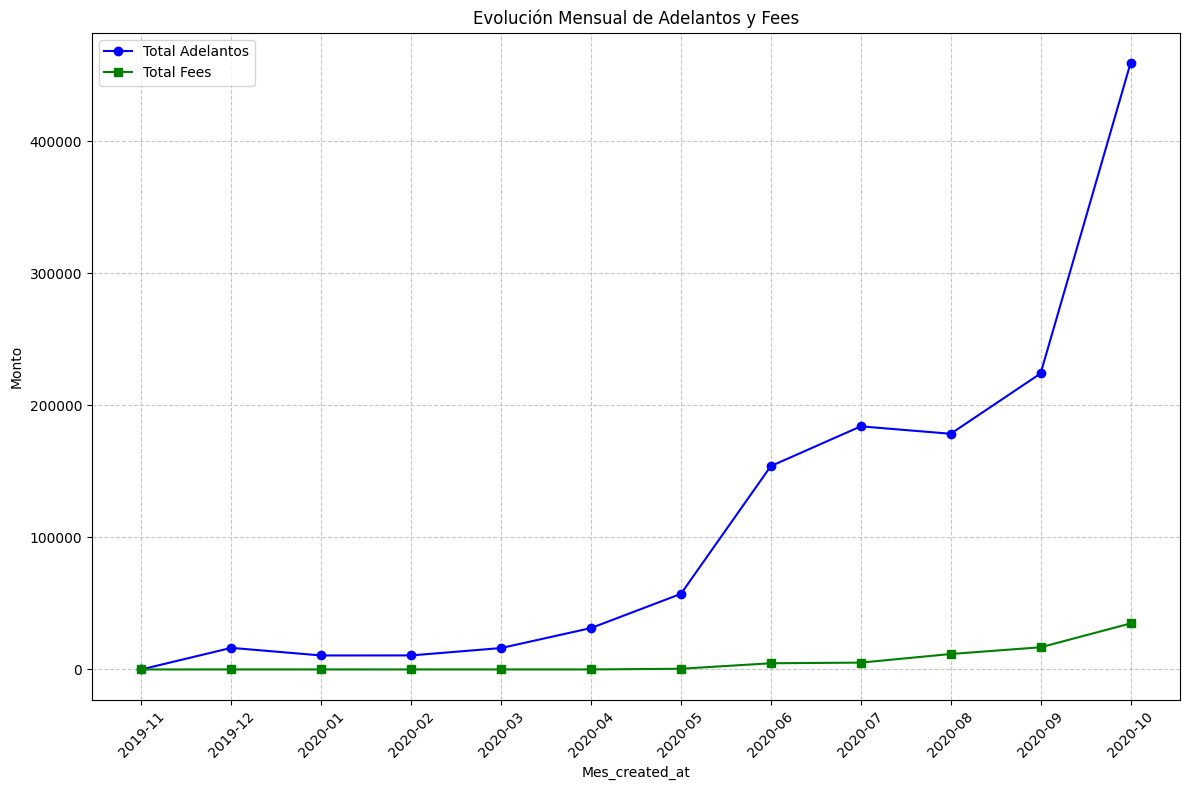

In [3]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar adelantos y fees en el mismo eje y
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_adelantos'], 
    marker='o', 
    label='Total Adelantos', 
    color='blue'
)
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['total_fees'], 
    marker='s', 
    label='Total Fees', 
    color='green'
)

# Configurar etiquetas y título
ax.set_xlabel('Mes_created_at')
ax.set_ylabel('Monto')
ax.set_title('Evolución Mensual de Adelantos y Fees')
ax.legend()  # Mostrar la leyenda para las líneas
ax.grid(True, linestyle='--', alpha=0.7)
plt.xticks(rotation=45)

# Mostrar el gráfico
plt.tight_layout()
plt.show()


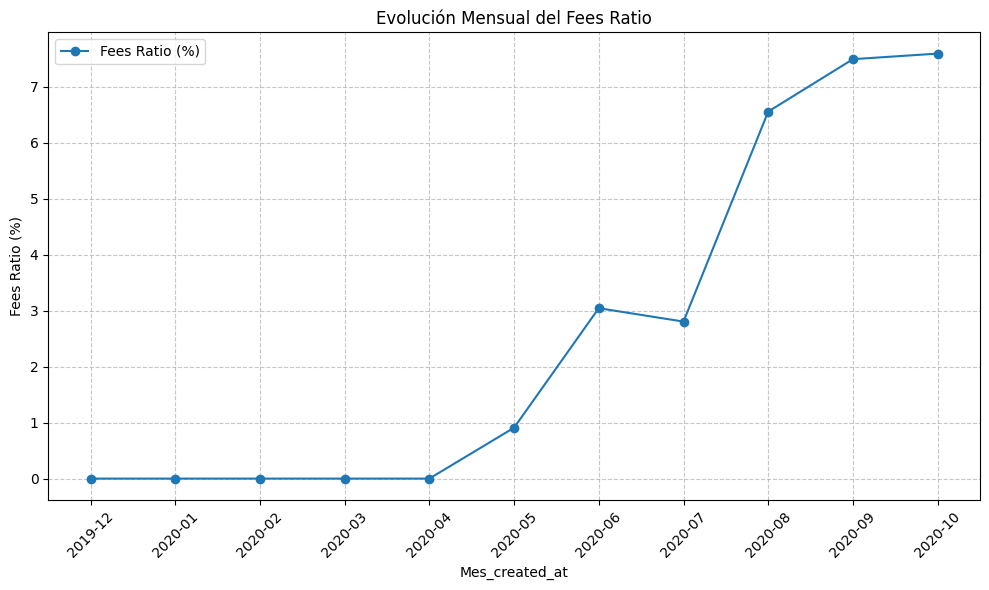

In [4]:
# Graficar la evolución del fees_ratio
plt.figure(figsize=(10, 6))
plt.plot(monthly_data['Mes_created_at'].astype(str), monthly_data['fees_ratio'], marker='o', label='Fees Ratio (%)')
plt.title('Evolución Mensual del Fees Ratio')
plt.xlabel('Mes_created_at')
plt.ylabel('Fees Ratio (%)')
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend()
plt.tight_layout()
plt.show()

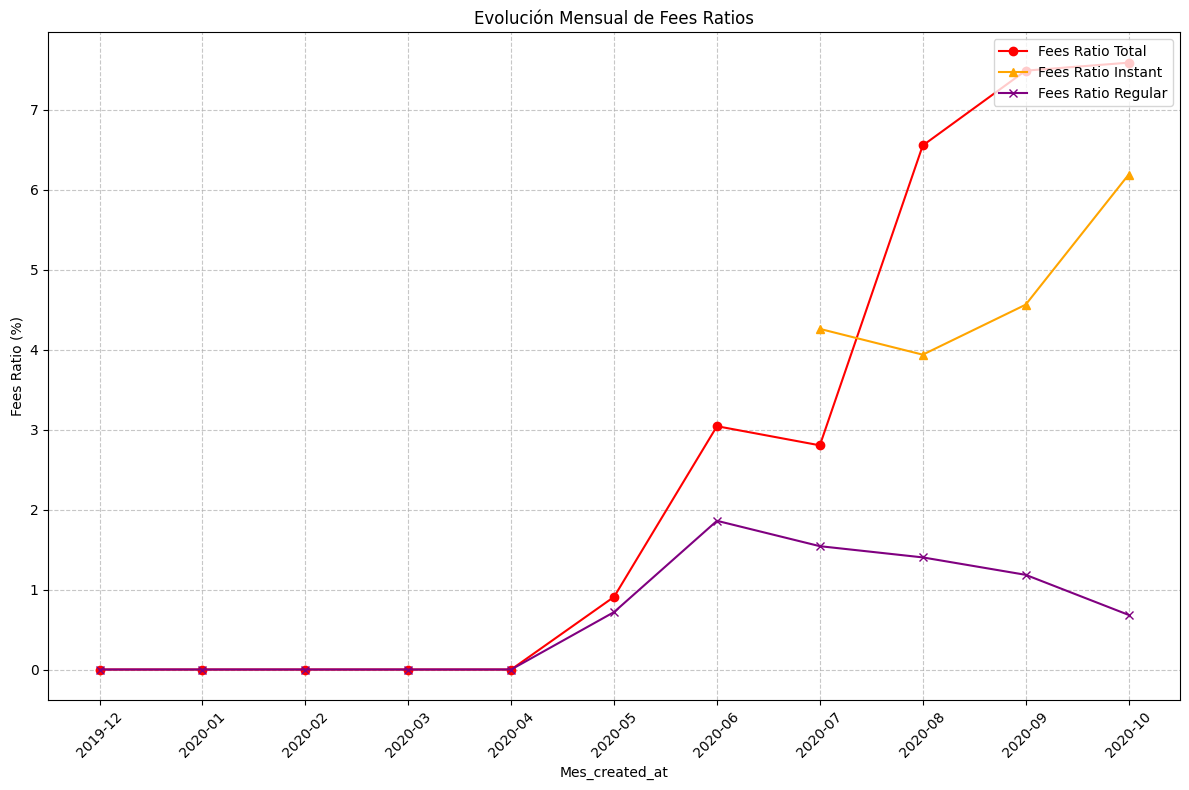

In [5]:
# Crear la figura y los ejes
fig, ax = plt.subplots(figsize=(12, 8))

# Graficar los tres ratios en el eje principal
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['fees_ratio'], 
    marker='o', 
    label='Fees Ratio Total', 
    color='red'
)
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['fees_ratio_instant'], 
    marker='^', 
    label='Fees Ratio Instant', 
    color='orange'
)
ax.plot(
    monthly_data['Mes_created_at'].astype(str), 
    monthly_data['fees_ratio_regular'], 
    marker='x', 
    label='Fees Ratio Regular', 
    color='purple'
)

# Configurar etiquetas y título
ax.set_xlabel('Mes_created_at')
ax.set_ylabel('Fees Ratio (%)')
ax.set_title('Evolución Mensual de Fees Ratios')
ax.legend(loc='upper right')  # Mostrar la leyenda
ax.grid(True, linestyle='--', alpha=0.7)

# Rotar las etiquetas del eje x para mejor visualización
plt.xticks(rotation=45)

# Ajustar el diseño y mostrar el gráfico
plt.tight_layout()
plt.show()


In [6]:
# Calcular las métricas mensuales segregadas por transfer_type
monthly_data = df_jo.groupby(['Mes_created_at', 'transfer_type']).agg(
    total_fees=('fee', 'sum'),
    total_adelantos=('amount', 'sum')
).reset_index()

# Calcular el ratio de fees sobre adelantos
monthly_data['fees_ratio'] = monthly_data['total_fees'] / monthly_data['total_adelantos'] * 100

monthly_data

,Mes_created_at,transfer_type,total_fees,total_adelantos,fees_ratio
0,2019-11,regular,0.0,1.0,0.000000
1,2019-12,regular,0.0,27297.0,0.000000
2,2020-01,regular,0.0,21587.0,0.000000
3,2020-02,regular,0.0,16653.0,0.000000
4,2020-03,regular,0.0,23549.0,0.000000
5,2020-04,regular,5.0,46093.0,0.010848
6,2020-05,regular,1285.0,94406.0,1.361142
7,2020-06,regular,8725.0,344186.0,2.534967
8,2020-07,instant,1390.0,40669.0,3.417837
9,2020-07,regular,9000.0,395368.0,2.276360


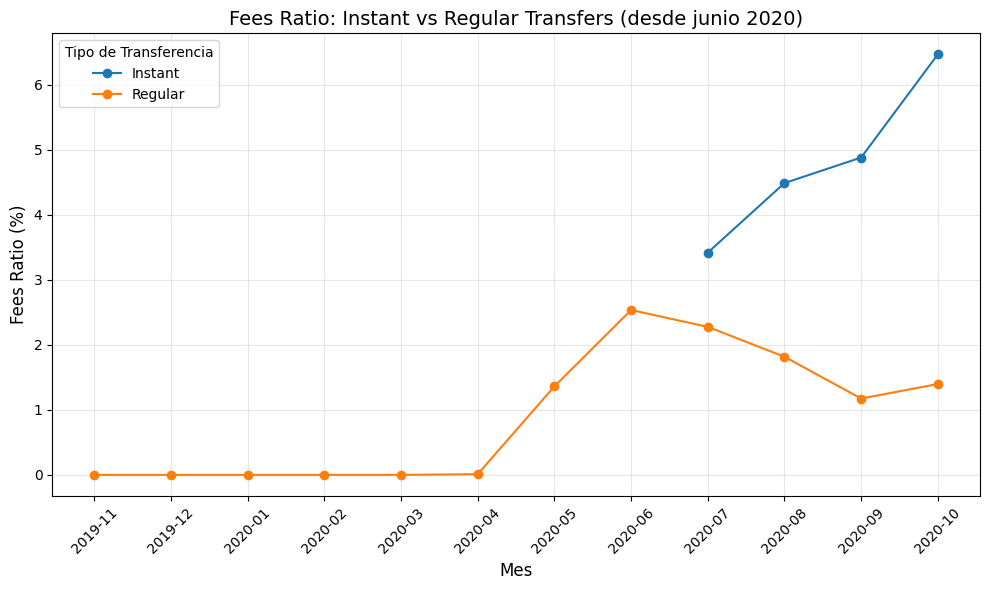

In [7]:
# Pivotar los datos para facilitar la gráfica
pivot_data = monthly_data.pivot(index='Mes_created_at', columns='transfer_type', values='fees_ratio')

# Asegurarse de que el índice sea un string para graficar
pivot_data.index = pivot_data.index.astype(str)

# Graficar los datos
plt.figure(figsize=(10, 6))
plt.plot(pivot_data.index, pivot_data['instant'], label='Instant', marker='o')
plt.plot(pivot_data.index, pivot_data['regular'], label='Regular', marker='o')

# Personalizar la gráfica
plt.title('Fees Ratio: Instant vs Regular Transfers (desde junio 2020)', fontsize=14)
plt.xlabel('Mes', fontsize=12)
plt.ylabel('Fees Ratio (%)', fontsize=12)
plt.xticks(rotation=45)
plt.legend(title='Tipo de Transferencia')
plt.grid(alpha=0.3)

# Mostrar la gráfica
plt.tight_layout()
plt.show()



In [8]:
# Crear columna 'Cohorte' que indica el mes de la primera solicitud de cada cliente
df_jo['Cohorte'] = df_jo.groupby('user_id')['created_at'].transform('min').dt.to_period('M')
df_jo.head(10)

,id_cr,id_fe,fe_cr_id,user_id,created_at,created_at_fe,amount,fee,stat_cr,stat_fe,...,charge_moment,moderated_at,reason,category,from_date,to_date,recovery_status,Mes_created_at,cash_request_received_date,Cohorte
0,5,0,NaN,804,2019-12-10 19:05:21.596873,NaT,100.0,NaN,rejected,NaN,...,NaN,2019-12-11 16:47:42.405646,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
1,70,0,NaN,231,2019-12-10 19:50:12.347780,NaT,100.0,NaN,rejected,NaN,...,NaN,2019-12-11 14:24:22.897988,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
2,7,0,NaN,191,2019-12-10 19:13:35.825460,NaT,100.0,NaN,rejected,NaN,...,NaN,2019-12-11 09:46:59.777728,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
3,10,0,NaN,761,2019-12-10 19:16:10.880172,NaT,99.0,NaN,rejected,NaN,...,NaN,2019-12-18 14:26:18.128407,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12
4,1594,0,NaN,7686,2020-05-06 09:59:38.877376,NaT,100.0,NaN,rejected,NaN,...,NaN,2020-05-07 09:21:55.320193,NaN,NaN,NaT,NaT,nice,2020-05,NaT,2020-05
5,2145,0,NaN,9489,2020-05-23 20:58:55.129432,NaT,100.0,NaN,money_back,NaN,...,NaN,2020-05-24 12:40:33.054910,NaN,NaN,NaT,NaT,completed,2020-05,2020-05-26,2020-05
6,3512,0,NaN,14631,2020-06-16 17:07:38.452652,NaT,100.0,NaN,rejected,NaN,...,NaN,2020-06-17 10:21:21.360742,NaN,NaN,NaT,NaT,nice,2020-06,NaT,2020-06
7,654,0,NaN,99000309,2020-02-10 01:11:53.808270,NaT,100.0,NaN,rejected,NaN,...,NaN,2020-02-10 09:11:21.350695,NaN,NaN,NaT,NaT,nice,2020-02,NaT,2020-01
8,5672,0,NaN,99002499,2020-06-28 12:06:33.712840,NaT,100.0,NaN,canceled,NaN,...,NaN,NaT,NaN,NaN,NaT,NaT,nice,2020-06,NaT,2020-06
9,71,0,NaN,897,2019-12-10 19:51:23.911206,NaT,90.0,NaN,rejected,NaN,...,NaN,2019-12-12 15:06:11.190299,NaN,NaN,NaT,NaT,nice,2019-12,NaT,2019-12


In [9]:
# Agrupar los datos por cohorte y mes para calcular las métricas mensuales
cohort_analysis = df_jo.groupby(['Cohorte', 'Mes_created_at']).agg(
    Num_Clientes=('user_id', 'nunique'),  # Número de clientes únicos por cohorte y mes
    Num_Solicitudes=('id_cr', 'nunique'),  # Total de solicitudes únicas por cohorte y mes
    Solicitudes_Instant=('transfer_type', lambda x: (x == 'instant').sum()),  # Solicitudes tipo 'instant' por cohorte y mes
    Solicitudes_Regular=('transfer_type', lambda x: (x == 'regular').sum()),  # Solicitudes tipo 'regular' por cohorte y mes
    Clientes_con_fees=('fee', lambda x: (x > 0).sum()),  # Clientes con fees por cohorte y mes
    CR=('id_cr', lambda ids: df_jo[df_jo['id_cr'].isin(ids) & df_jo['cash_request_received_date'].notnull()]['amount'].sum()),

    Fees=('fee', 'sum'),  # Total de fees por cohorte y mes
    # Contar las líneas con 'stat_fe' == 'accepted'
    paid_fees=('stat_fe', lambda x: (x == 'accepted').sum()),  
    # Contar las líneas con 'stat_fe' != 'accepted'
    non_paid_fees=('stat_fe', lambda x: (x != 'accepted').sum()),
    # Sumar 'total_amount' cuando 'stat_fe' == 'accepted'
    total_paid_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'accepted'].sum()),
    # Sumar 'total_amount' cuando 'stat_fe' != 'accepted'
    total_non_paid_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] != 'accepted'].sum()),
     # Contar las líneas con 'stat_cr' == 'money_back'
    paid_cr=('stat_cr', lambda x: (x == 'money_back').sum()),  
    # Contar las líneas con 'stat_fe' != 'accepted'
    non_paid_cr=('stat_cr', lambda x: (x != 'money_back').sum()),
    # Sumar 'total_amount' cuando 'stat_fe' == 'accepted'
    total_paid_cr=('amount', lambda x: x[df_jo.loc[x.index, 'stat_cr'] == 'money_back'].sum()),
    # Sumar 'total_amount' cuando 'stat_fe' != 'accepted'
    total_non_paid_cr=('amount', lambda x: x[df_jo.loc[x.index, 'stat_cr'] != 'money_back'].sum()),
    # Métrica de "credit lapse" (diferencia entre reimbursement_date y created_at)
    credit_lapse=('reimbursement_date', lambda x: (x - df_jo.loc[x.index, 'created_at']).dt.days.mean()),
    # Métrica de "credit payment lapse" (diferencia entre money_back_date y reimbursement_date)
    credit_payment_lapse=('money_back_date', lambda x: (x - df_jo.loc[x.index, 'reimbursement_date']).dt.days.mean())

).reset_index()

# Calcular los porcentajes de non_paid_fees
cohort_analysis['paid_fees_percent_qty'] = (cohort_analysis['paid_fees'] / (cohort_analysis['paid_fees'] + cohort_analysis['non_paid_fees']))
cohort_analysis['paid_fees_percent_amount'] = (cohort_analysis['total_paid_fees'] / cohort_analysis['Fees'])   # % en monto
cohort_analysis['paid_cr_percent_qty'] = (cohort_analysis['paid_cr'] / (cohort_analysis['paid_cr'] + cohort_analysis['non_paid_cr']))
cohort_analysis['paid_cr_percent_amount'] = (cohort_analysis['total_paid_cr'] / cohort_analysis['CR'])   # % en monto
cohort_analysis['index'] = (cohort_analysis['total_paid_fees'] / cohort_analysis['total_paid_cr'])   # % index

# Eliminar las columnas de pago y no pago
cohort_sizes_monthly = cohort_analysis.drop(
    ['paid_fees', 'non_paid_fees', 'total_paid_fees', 'total_non_paid_fees','paid_cr', 'non_paid_cr', 'total_paid_cr', 'total_non_paid_cr'], axis=1, errors='ignore')

# Mostrar los resultados de las cohortes por mes
cohort_analysis


,Cohorte,Mes_created_at,Num_Clientes,Num_Solicitudes,Solicitudes_Instant,Solicitudes_Regular,Clientes_con_fees,CR,Fees,paid_fees,...,non_paid_cr,total_paid_cr,total_non_paid_cr,credit_lapse,credit_payment_lapse,paid_fees_percent_qty,paid_fees_percent_amount,paid_cr_percent_qty,paid_cr_percent_amount,index
0,2019-11,2019-11,1,1,0,1,0,0.0,0.0,0,...,1,0.0,1.0,16.000000,NaN,0.000000,NaN,0.000000,NaN,NaN
1,2019-11,2019-12,1,1,0,1,0,0.0,0.0,0,...,1,0.0,100.0,6.000000,NaN,0.000000,NaN,0.000000,NaN,NaN
2,2019-11,2020-04,1,1,0,1,0,100.0,0.0,0,...,0,100.0,0.0,14.000000,8.000000,0.000000,NaN,1.000000,1.000000,0.000000
3,2019-11,2020-05,1,1,0,5,5,50.0,25.0,1,...,0,50.0,0.0,125.000000,-45.000000,0.200000,0.200000,1.000000,1.000000,0.100000
4,2019-11,2020-08,1,1,2,0,2,20.0,10.0,2,...,0,20.0,0.0,55.000000,-8.000000,1.000000,1.000000,1.000000,1.000000,0.500000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
68,2020-08,2020-09,291,342,433,59,351,27020.0,1755.0,253,...,179,23710.0,11810.0,34.894309,7.150150,0.514228,0.720798,0.636179,0.877498,0.053353
69,2020-08,2020-10,245,279,310,29,283,21510.0,1415.0,230,...,43,23430.0,3280.0,24.241888,4.027027,0.678466,0.812721,0.873156,1.089261,0.049082
70,2020-09,2020-09,1989,2221,3158,204,2379,190776.0,11895.0,1643,...,1186,178558.0,85449.0,31.351279,9.300627,0.488697,0.690626,0.647234,0.935956,0.046007
71,2020-09,2020-10,680,728,867,70,846,55440.0,4230.0,635,...,117,57985.0,7585.0,24.610459,4.122892,0.677695,0.750591,0.875133,1.045905,0.054756


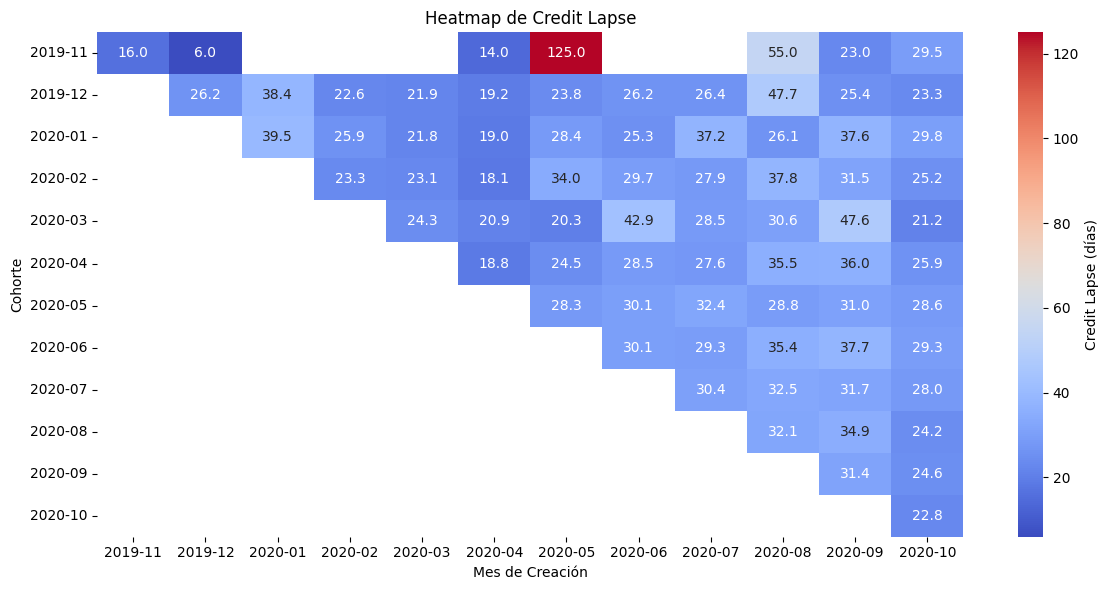

In [10]:
# Crear los datos para el heatmap
heatmap_data = cohort_analysis.pivot(
    index='Cohorte', 
    columns='Mes_created_at', 
    values='credit_lapse'
)

# Crear la figura para el heatmap
plt.figure(figsize=(12, 6))
sns.heatmap(
    heatmap_data, 
    annot=True, 
    fmt=".1f", 
    cmap="coolwarm", 
    cbar_kws={'label': 'Credit Lapse (días)'}
)

# Personalizar el heatmap
plt.title('Heatmap de Credit Lapse')
plt.xlabel('Mes de Creación')
plt.ylabel('Cohorte')
plt.tight_layout()
plt.show()


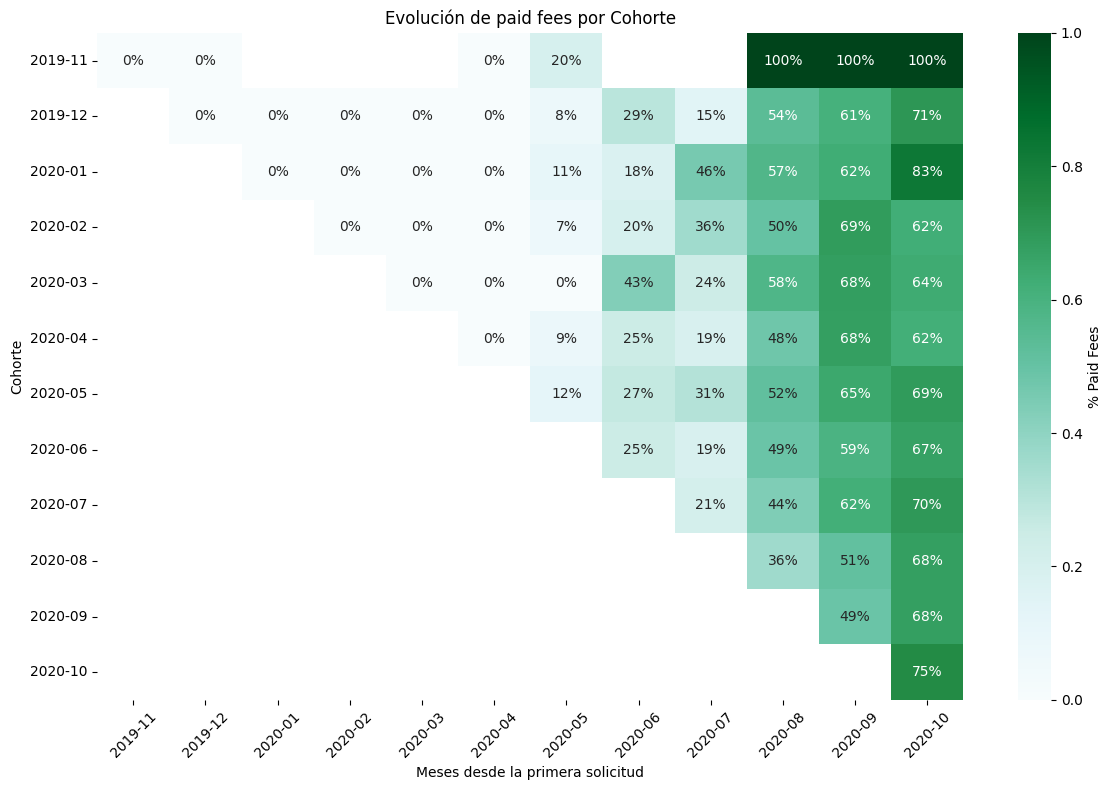

In [11]:
# Pivotar los datos para crear una matriz de fees pagados por cohorte para cada mes
paid_fees_heatmap_data = cohort_analysis.pivot(index='Cohorte', columns='Mes_created_at', values='paid_fees_percent_qty')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(paid_fees_heatmap_data, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='BuGn', cbar_kws={'label': '% Paid Fees'})

# Añadir etiquetas y título
plt.title('Evolución de paid fees por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Mostrar el heatmap
plt.tight_layout()
plt.show()


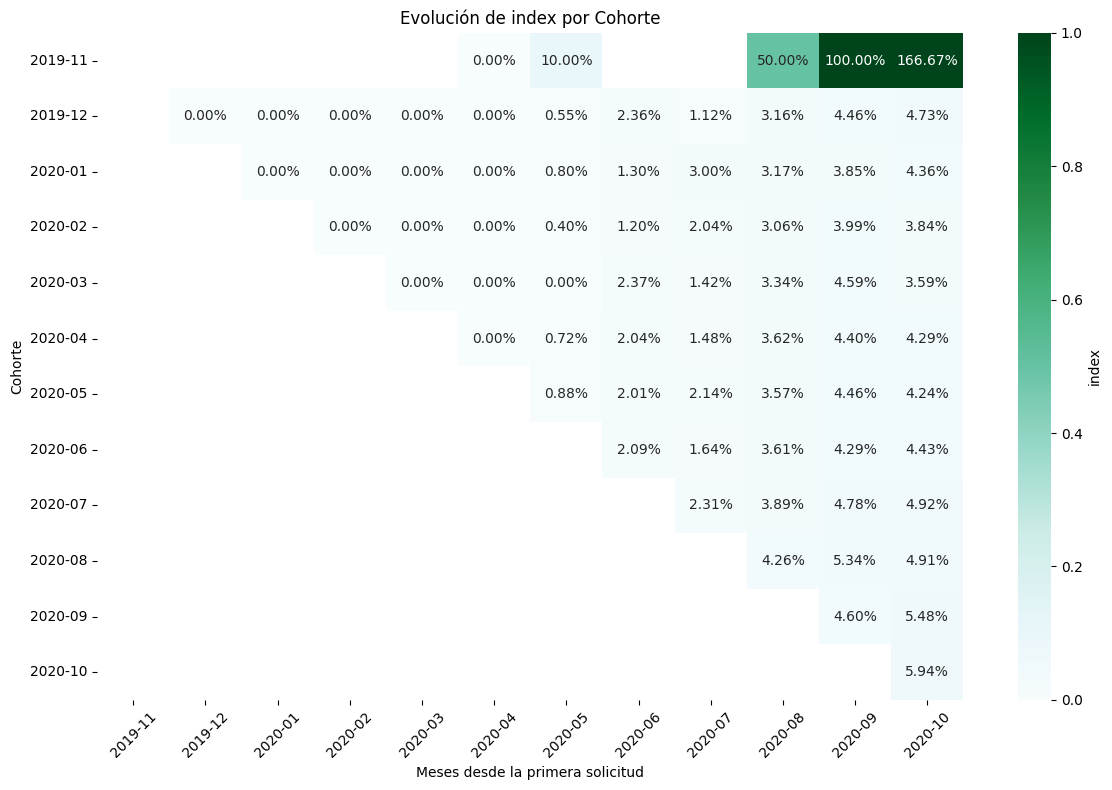

In [12]:
# Pivotar los datos para crear una matriz de index por cohorte para cada mes
paid_fees_heatmap_data = cohort_analysis.pivot(index='Cohorte', columns='Mes_created_at', values='index')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(paid_fees_heatmap_data, annot=True, fmt='.2%', vmin=0.0, vmax=1.0, cmap='BuGn', cbar_kws={'label': 'index'})

# Añadir etiquetas y título
plt.title('Evolución de index por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Mostrar el heatmap
plt.tight_layout()
plt.show()


In [13]:
cohort_analysis_2 = (
    df_jo.groupby(['user_id', 'Mes_created_at'], as_index=False)
    .agg(
        # Sumar los valores de 'fee' donde 'stat_fe' es igual a 'accepted'
        total_paid_fees=('fee', lambda x: x[df_jo.loc[x.index, 'stat_fe'] == 'accepted'].sum()),
        
        # Contar los valores únicos de 'stat_cr' donde su valor sea 'money_back'
        total_paid_cr=('amount', lambda x: x[df_jo.loc[x.index, 'stat_cr'] == 'money_back'].unique().sum()),

        # Calcular la media de 'to_reimbur_cash'
        #reimburse_lapse=('to_reimbur_cash', 'mean'),

        # Contar los valores únicos de 'id_cr' donde 'stat_cr' es igual a 'money_back'
        Num_Solicitudes=('id_cr', lambda x: x[df_jo.loc[x.index, 'stat_cr'] == 'money_back'].nunique())
    )
)

# Restablecer el índice para un DataFrame limpio (opcional, ya garantizado por as_index=False)
cohort_analysis_2.reset_index(drop=True, inplace=True)

# Calcular el índice como porcentaje entre 'total_paid_fees' y 'total_paid_cr'
cohort_analysis_2['index'] = (
    cohort_analysis_2['total_paid_fees'] / cohort_analysis_2['total_paid_cr']
) * 100

# Reemplazar valores 'inf' con 0 para manejar divisiones por cero
cohort_analysis_2['index'] = cohort_analysis_2['index'].replace(np.inf, 0)

# Calcular la fecha del último pedido por usuario a partir del DataFrame original
df_jo['created_at'] = pd.to_datetime(df_jo['created_at'])  # Asegurarse de que el formato sea datetime
last_order_per_user = (
    df_jo.groupby('user_id')['created_at']
    .max()  # Obtener la fecha más reciente de pedido para cada usuario
    .dt.to_period('M')  # Convertir a periodo mensual
    .reset_index()  # Restablecer el índice para facilitar el merge
)

# Incorporar la fecha del último pedido en el DataFrame de análisis de cohortes
cohort_analysis_2 = pd.merge(
    cohort_analysis_2,
    last_order_per_user.rename(columns={'created_at': 'last_order'}),
    on='user_id',
    how='left'
)

# Resultado final del DataFrame de análisis de cohortes
cohort_analysis_2



,user_id,Mes_created_at,total_paid_fees,total_paid_cr,Num_Solicitudes,index,last_order
0,34,2020-04,0.0,0.0,0,NaN,2020-04
1,35,2019-12,0.0,0.0,0,NaN,2020-09
2,35,2020-01,0.0,0.0,0,NaN,2020-09
3,35,2020-02,0.0,0.0,0,NaN,2020-09
4,35,2020-03,0.0,0.0,0,NaN,2020-09
...,...,...,...,...,...,...,...
20327,99030337,2020-07,10.0,100.0,1,10.0,2020-10
20328,99030337,2020-10,5.0,100.0,1,5.0,2020-10
20329,99030367,2020-10,5.0,50.0,1,10.0,2020-10
20330,99030404,2020-10,5.0,100.0,1,5.0,2020-10


In [14]:
# Filtrar el DataFrame para clientes con transfer_type 'regular' y 'instant'
regular_clients = df_jo[df_jo['transfer_type'] == 'regular']
instant_clients = df_jo[df_jo['transfer_type'] == 'instant']

# Identificar los usuarios únicos en cada tipo de transferencia
regular_users = set(regular_clients['user_id'].unique())
instant_users = set(instant_clients['user_id'].unique())

# Clientes con 'regular' o 'instant' solamente (sin mezcla)
regular_only_users = regular_users - instant_users
instant_only_users = instant_users - regular_users

# Clientes con una mezcla de 'regular' e 'instant'
mix_users = regular_users & instant_users


In [15]:
# Create a dictionary to classify users based on their type
user_classification = {
    user: 'mixed' for user in mix_users
}
user_classification.update({user: 'regular' for user in regular_only_users})
user_classification.update({user: 'instant' for user in instant_only_users})

# Map the classification to the 'user_id' column
cohort_analysis_2['classification'] = cohort_analysis_2['user_id'].map(user_classification)

# Agrupar por 'user_id' y calcular las métricas necesarias
grouped_cohort = cohort_analysis_2.groupby('user_id', as_index=False).agg(
    Num_Solicitudes=('Num_Solicitudes', 'sum'),  # Total de solicitudes
    total_paid_cr=('total_paid_cr', 'sum'),      # Total de pagos en CR
    total_paid_fees=('total_paid_fees', 'sum'),  # Total de tarifas pagadas
    index=('index', 'mean'),                     # Media del índice
    classification=('classification', 'first')  # Clasificación de usuario
)

# Ordenar usuarios por las métricas calculadas
sorted_grouped_cohort = grouped_cohort.sort_values(
    by=['classification','Num_Solicitudes', 'index', 'total_paid_fees'], 
    ascending=[False,False, False, False]
)



# Seleccionar los 30 usuarios principales
top_30_users = sorted_grouped_cohort.head(30)

# Mostrar los 30 usuarios principales con clasificación
top_30_users = pd.DataFrame(top_30_users)

# Display the DataFrame
top_30_users

# Filtrar para usuarios con clasificación 'mixed'
mixed_users = sorted_grouped_cohort[sorted_grouped_cohort['classification'] == 'mixed']

# Mostrar el DataFrame filtrado
mixed_users=pd.DataFrame(mixed_users)

mixed_users


,user_id,Num_Solicitudes,total_paid_cr,total_paid_fees,index,classification
69,526,11,920.0,25.0,2.050032,mixed
38,274,11,900.0,5.0,0.555556,mixed
289,1946,11,900.0,5.0,0.555556,mixed
295,1987,10,900.0,35.0,3.888889,mixed
178,1267,10,1000.0,20.0,2.000000,mixed
...,...,...,...,...,...,...
11619,99017206,0,0.0,0.0,NaN,mixed
11630,99018460,0,0.0,0.0,NaN,mixed
11642,99019304,0,0.0,0.0,NaN,mixed
11716,99022251,0,0.0,0.0,NaN,mixed


In [16]:
# Pivot to show months as columns
cohort_amount_top20 = top_20_users.pivot(index='user_id', columns='Mes_created_at', values='index')

# Display the result
cohort_amount_top20


NameError: name 'top_20_users' is not defined

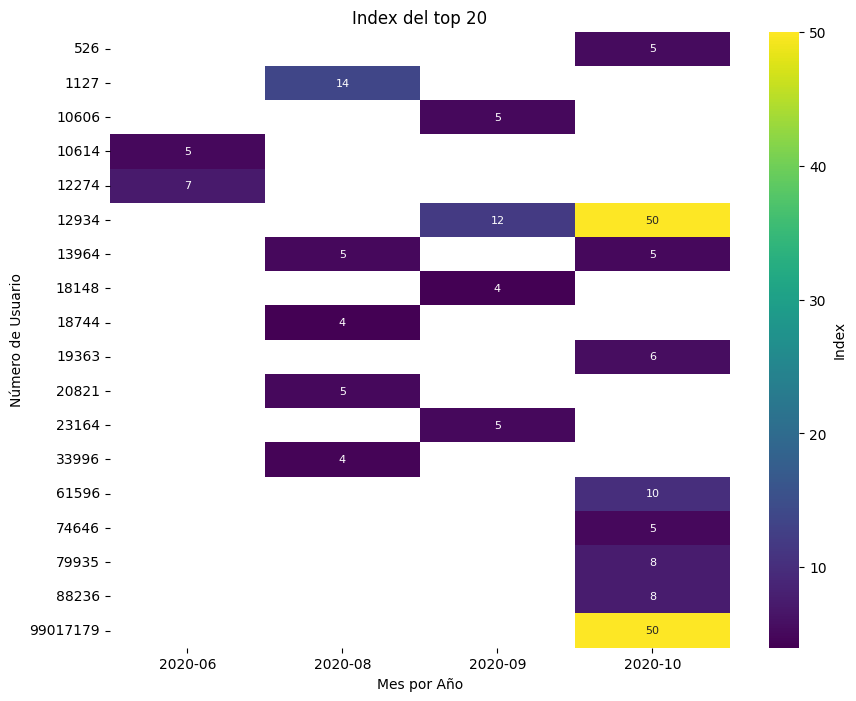

In [ ]:
# Graficar la cantidad de adelanto de efectivo de un cohorte por meses y número de usuarios
plt.figure(figsize=(10, 8))
plt.title('Index del top 20')
sns.heatmap(data=cohort_amount_top20, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Index'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()

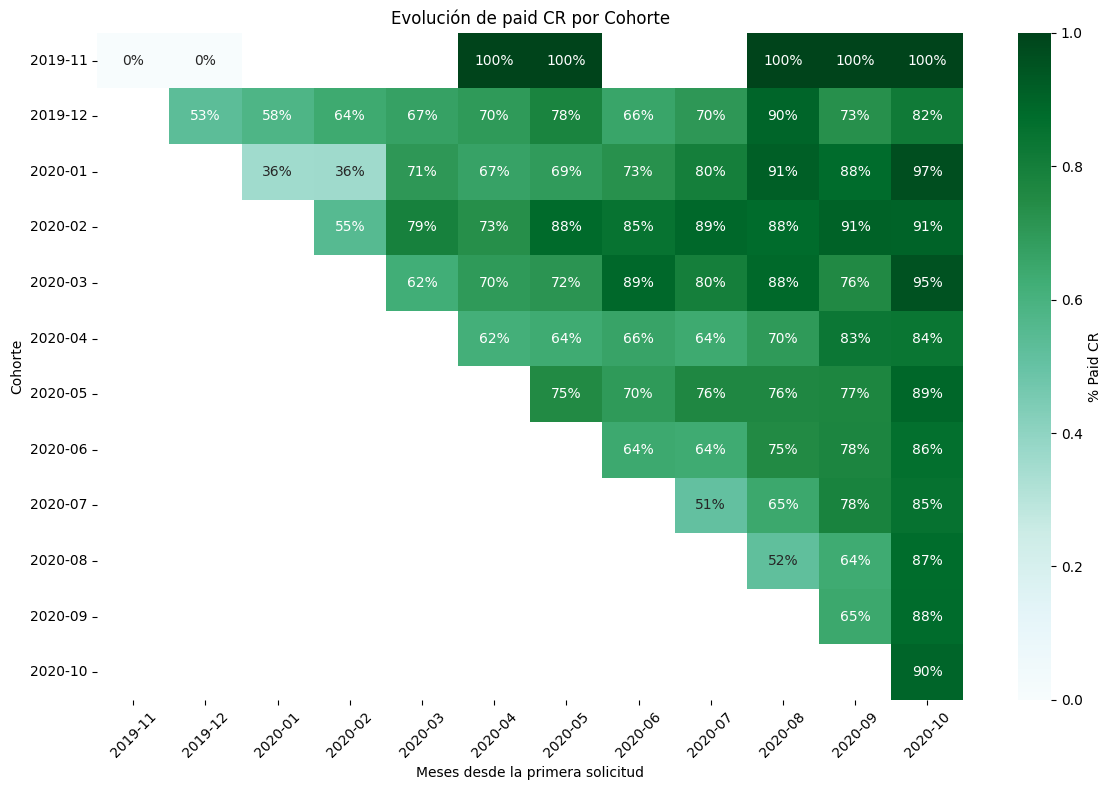

In [ ]:
# Pivot the data to create a matrix of paid_cr per cohort for each month
paid_cr_heatmap_data = cohort_sizes_monthly.pivot(index='Cohorte', columns='Mes_created_at', values='paid_cr_percent_qty')

# Create the heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(paid_cr_heatmap_data, annot=True, fmt='.0%', vmin=0.0, vmax=1.0, cmap='BuGn', cbar_kws={'label': '% Paid CR'})

# Add labels and title
plt.title('Evolución de paid CR por Cohorte')
plt.xlabel('Meses desde la primera solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)

# Show the heatmap
plt.tight_layout()
plt.show()

In [ ]:
cohort_ltv_monthly = cohort_analysis.groupby(['Cohorte', 'Mes_created_at']).agg(
    Total_Fees=('Fees', 'sum'),  
    Clientes=('Num_Clientes', 'sum') 
).reset_index()


# Calcular el LTV mensual
cohort_ltv_monthly['LTV_Mensual'] = cohort_ltv_monthly['Total_Fees'] / cohort_ltv_monthly['Clientes']
cohort_ltv_monthly

,Cohorte,Mes_created_at,Total_Fees,Clientes,LTV_Mensual
0,2019-11,2019-11,0.0,1,0.000000
1,2019-11,2019-12,0.0,1,0.000000
2,2019-11,2020-04,0.0,1,0.000000
3,2019-11,2020-05,25.0,1,25.000000
4,2019-11,2020-08,10.0,1,10.000000
...,...,...,...,...,...
68,2020-08,2020-09,1755.0,291,6.030928
69,2020-08,2020-10,1415.0,245,5.775510
70,2020-09,2020-09,11890.0,1988,5.980885
71,2020-09,2020-10,4225.0,679,6.222386


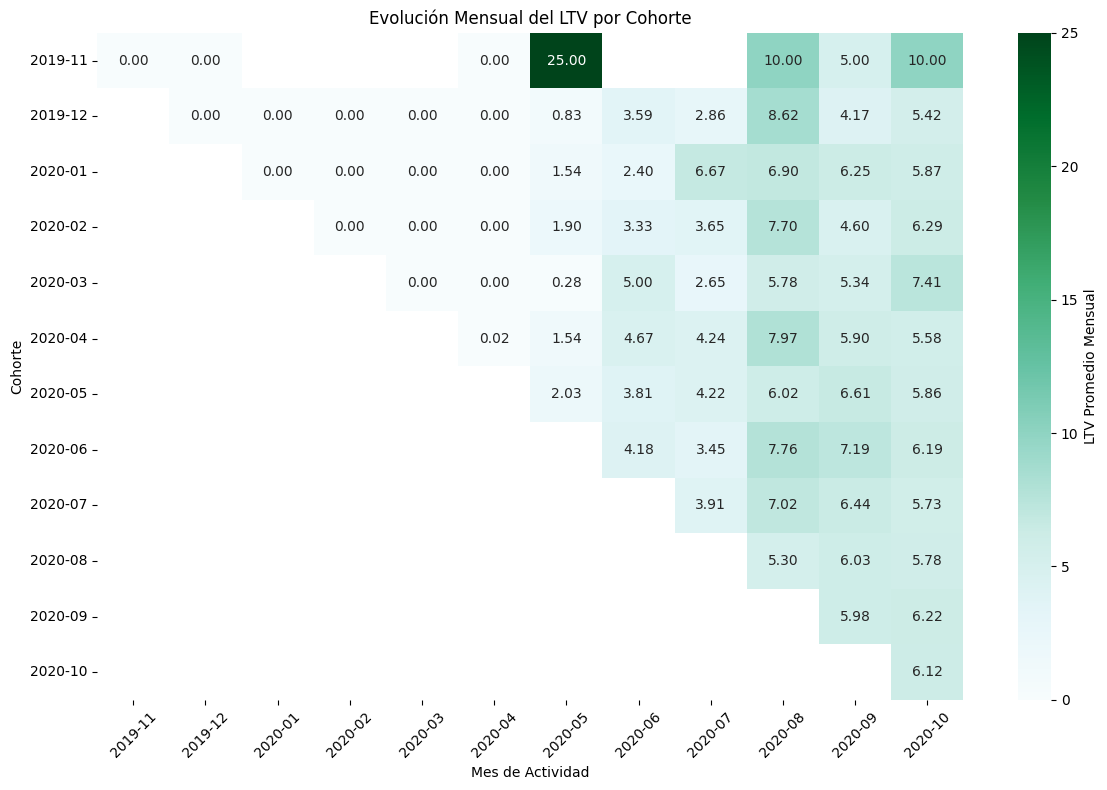

In [ ]:
# Reorganizar los datos en una matriz para el heatmap
ltv_matrix = cohort_ltv_monthly.pivot(index='Cohorte', columns='Mes_created_at', values='LTV_Mensual')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(data=ltv_matrix, annot=True, fmt='.2f', cmap='BuGn', cbar_kws={'label': 'LTV Promedio Mensual'})
plt.title('Evolución Mensual del LTV por Cohorte')
plt.xlabel('Mes de Actividad')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [ ]:
# Filter for Cohorte '2020-06' and calculate unique id_cr sums per user and month
amount_2020_06 = (
    df_jo[
        (df_jo['Cohorte'] == '2020-06') &  # Filter cohort
        (df_jo['cash_request_received_date'].notna())  # Ensure cash_request_received_date is not null
    ]
    .drop_duplicates(subset=['user_id', 'Mes_created_at', 'id_cr'])  # Remove duplicate id_cr
    .groupby(['user_id', 'Mes_created_at'])['amount']
    .sum()
    .reset_index()
)


# Filter for the top 10 users
cohort_amount_2020_06_top10 = amount_2020_06[amount_2020_06['user_id'].isin(top_10_users['user_id'])]

# Pivot to show months as columns
cohort_amount_2020_06_top10 = cohort_amount_2020_06_top10.pivot(index='user_id', columns='Mes_created_at', values='amount')

# Display the result
cohort_amount_2020_06_top10


Mes_created_at,2020-06,2020-07,2020-08,2020-09,2020-10
user_id,,,,,
9901,50.0,100.0,NaN,NaN,NaN
10086,40.0,115.0,100.0,NaN,100.0
12441,100.0,100.0,100.0,100.0,200.0
13851,NaN,NaN,150.0,NaN,100.0
15219,NaN,NaN,NaN,NaN,50.0
20583,20.0,50.0,65.0,NaN,NaN
22084,100.0,100.0,NaN,NaN,50.0
99003767,100.0,NaN,NaN,NaN,NaN
99006334,50.0,50.0,NaN,NaN,NaN


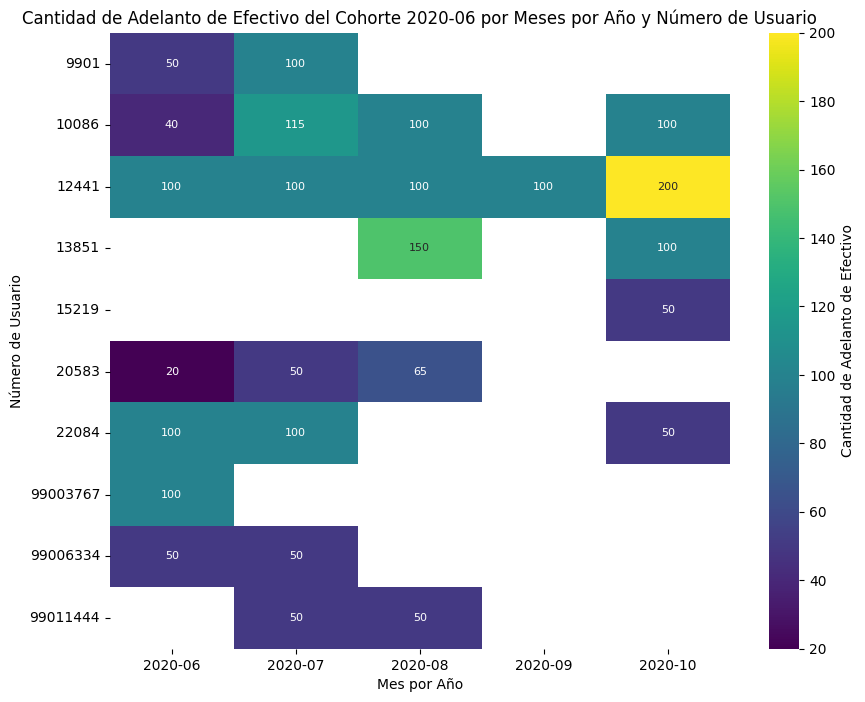

In [ ]:
# Graficar la cantidad de adelanto de efectivo de un cohorte por meses y número de usuarios
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-06 por Meses por Año y Número de Usuario')
sns.heatmap(data=cohort_amount_2020_06_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Mes por Año')
plt.ylabel('Número de Usuario')
plt.show()

In [ ]:
# Agregar columnas de temporalidad
# Semana y mes de la solicitud
df_jo['Semana_Mes'] = df_jo['created_at'].dt.strftime('%U_%B') + '_' + df_jo['Mes_created_at'].dt.strftime('%Y')
# Día y semana de la solicitud
df_jo['Dia_Semana'] = df_jo['created_at'].dt.strftime('%A') + '_' + df_jo['Semana_Mes']
# Hora y dia de la solicitud
df_jo['Hora_Dia'] = df_jo['created_at'].dt.hour.astype(str) + '_' + df_jo['Dia_Semana']
df_jo.head()

,id_cr,amount,stat_cr,created_at,user_id,active,moderated_at,reimbursement_date,cash_request_received_date,money_back_date,...,to_receive_ini,to_receive_bank,to_reimbur,to_reimbur_cash,to_end,to_send,Cohorte,Semana_Mes,Dia_Semana,Hora_Dia
0,5,100.0,rejected,2019-12-10 19:05:21.596873,804,1,2019-12-11 16:47:42.405646,2020-01-09 19:05:21.596363,NaT,NaT,...,NaT,NaT,29 days 23:59:59.999490,NaT,NaT,NaT,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
1,70,100.0,rejected,2019-12-10 19:50:12.347780,231,1,2019-12-11 14:24:22.897988,2020-01-09 19:50:12.347780,NaT,NaT,...,NaT,NaT,30 days 00:00:00,NaT,NaT,NaT,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
2,7,100.0,rejected,2019-12-10 19:13:35.825460,191,1,2019-12-11 09:46:59.777728,2020-01-09 19:13:35.825041,NaT,NaT,...,NaT,NaT,29 days 23:59:59.999581,NaT,NaT,NaT,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
3,10,99.0,rejected,2019-12-10 19:16:10.880172,761,1,2019-12-18 14:26:18.128407,2020-01-09 19:16:10.879606,NaT,NaT,...,NaT,NaT,29 days 23:59:59.999434,NaT,NaT,NaT,2019-12,49_December_2019,Tuesday_49_December_2019,19_Tuesday_49_December_2019
4,1594,100.0,rejected,2020-05-06 09:59:38.877376,7686,1,2020-05-07 09:21:55.320193,2020-06-05 22:00:00.000000,NaT,NaT,...,NaT,NaT,30 days 12:00:21.122624,NaT,NaT,NaT,2020-05,18_May_2020,Wednesday_18_May_2020,9_Wednesday_18_May_2020


In [ ]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y semana
cohort_weekly_amount = df_jo[df_jo['Cohorte'] == '2020-06'].groupby(['user_id','Semana_Mes'])['amount'].sum().reset_index()
cohort_weekly_amount

,user_id,Semana_Mes,amount
0,204,24_June_2020,100.0
1,204,25_June_2020,30.0
2,204,28_July_2020,50.0
3,204,34_August_2020,140.0
4,277,22_June_2020,100.0
...,...,...,...
4737,99027563,34_August_2020,200.0
4738,99027563,42_October_2020,100.0
4739,99030337,22_June_2020,140.0
4740,99030337,28_July_2020,300.0


In [ ]:
# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_weekly_amount_top10 = cohort_weekly_amount[cohort_weekly_amount['user_id'].isin(top_10_users['user_id'])]
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.pivot(index='user_id', columns='Semana_Mes', values='amount')
cohort_weekly_amount_top10

Semana_Mes,22_June_2020,23_June_2020,24_June_2020,25_June_2020,26_July_2020,26_June_2020,27_July_2020,28_July_2020,29_July_2020,30_August_2020,...,33_August_2020,35_September_2020,36_September_2020,37_September_2020,38_September_2020,39_October_2020,40_October_2020,41_October_2020,42_October_2020,43_October_2020
user_id,,,,,,,,,,,,,,,,,,,,,
9901,NaN,400.0,250.0,NaN,NaN,NaN,200.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,10.0,NaN,50.0,NaN,NaN
10086,460.0,NaN,NaN,NaN,65.0,NaN,NaN,NaN,490.0,NaN,...,300.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN
12441,100.0,600.0,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,...,NaN,100.0,NaN,NaN,NaN,NaN,100.0,NaN,NaN,100.0
13851,NaN,100.0,NaN,100.0,100.0,NaN,600.0,200.0,300.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,NaN,NaN
15219,NaN,NaN,300.0,80.0,100.0,NaN,150.0,100.0,100.0,NaN,...,50.0,50.0,50.0,NaN,50.0,NaN,50.0,NaN,NaN,NaN
20583,NaN,NaN,NaN,130.0,NaN,NaN,590.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22084,NaN,NaN,NaN,100.0,NaN,NaN,NaN,100.0,NaN,NaN,...,150.0,200.0,200.0,100.0,NaN,NaN,50.0,NaN,NaN,NaN
99003767,100.0,NaN,NaN,NaN,345.0,100.0,200.0,250.0,150.0,50.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99006334,NaN,NaN,NaN,50.0,NaN,NaN,50.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,100.0,NaN,NaN,NaN,NaN,NaN


In [ ]:
# Seleccionar las primeras 10 semanas
cohort_weekly_amount_top10 = cohort_weekly_amount_top10.loc[:,cohort_weekly_amount_top10.columns[9:19]]
cohort_weekly_amount_top10

Semana_Mes,30_August_2020,30_July_2020,31_August_2020,32_August_2020,33_August_2020,35_September_2020,36_September_2020,37_September_2020,38_September_2020,39_October_2020
user_id,,,,,,,,,,
9901,NaN,NaN,400.0,200.0,NaN,NaN,NaN,NaN,NaN,10.0
10086,NaN,115.0,NaN,NaN,300.0,NaN,NaN,NaN,NaN,NaN
12441,NaN,NaN,100.0,NaN,NaN,100.0,NaN,NaN,NaN,NaN
13851,NaN,100.0,50.0,500.0,NaN,NaN,NaN,NaN,NaN,NaN
15219,NaN,280.0,NaN,NaN,50.0,50.0,50.0,NaN,50.0,NaN
20583,NaN,NaN,415.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
22084,NaN,NaN,NaN,300.0,150.0,200.0,200.0,100.0,NaN,NaN
99003767,50.0,NaN,50.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
99006334,NaN,NaN,NaN,1550.0,NaN,NaN,NaN,NaN,100.0,NaN


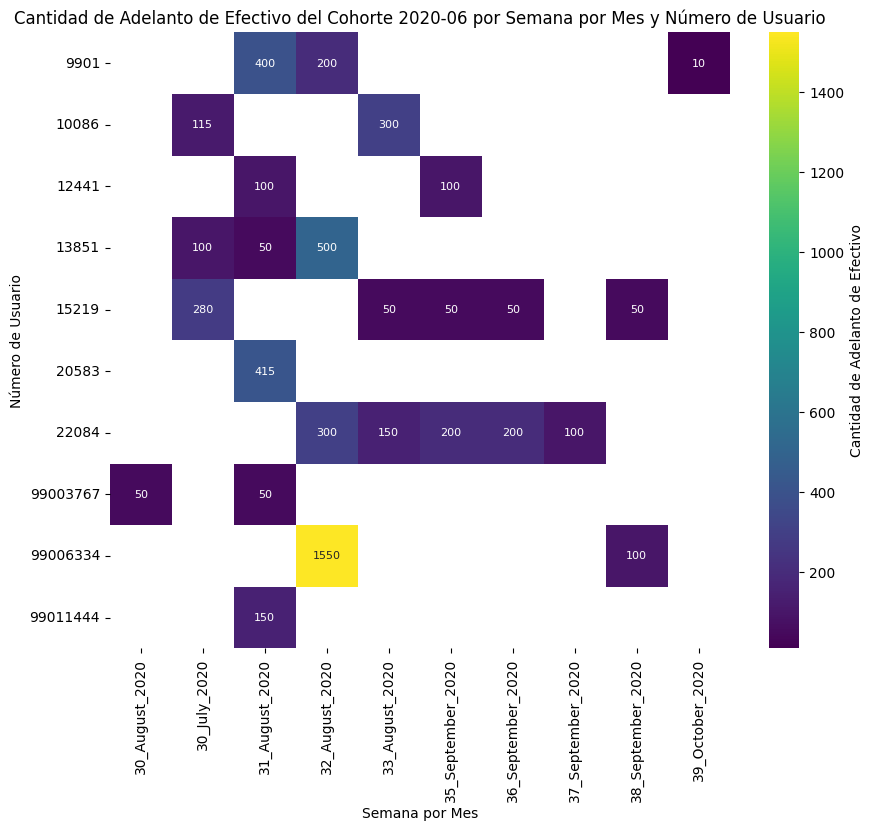

In [ ]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios por semana
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-06 por Semana por Mes y Número de Usuario')
sns.heatmap(data=cohort_weekly_amount_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Semana por Mes')
plt.ylabel('Número de Usuario')
plt.show()


In [ ]:
# Filtrar para calcular la cantidad de adelanto de efectivo por cohorte y día de la semana
cohort_daily_amount = df_jo[ (df_jo['Cohorte'] == '2020-06') & (df_jo['Semana_Mes'] == '32_August_2020') ].groupby(['user_id', 'Dia_Semana'])['amount'].sum().reset_index()
cohort_daily_amount

,user_id,Dia_Semana,amount
0,1878,Sunday_32_August_2020,100.0
1,1989,Friday_32_August_2020,200.0
2,2408,Thursday_32_August_2020,200.0
3,2434,Saturday_32_August_2020,50.0
4,3403,Friday_32_August_2020,100.0
...,...,...,...
336,99019005,Tuesday_32_August_2020,50.0
337,99019257,Monday_32_August_2020,800.0
338,99019798,Friday_32_August_2020,200.0
339,99021977,Thursday_32_August_2020,300.0


In [ ]:
# Filtrar para incluir solo los 10 usuarios seleccionados
cohort_daily_amount_top10 = cohort_daily_amount[cohort_daily_amount['user_id'].isin(top_10_users['user_id'])]
cohort_daily_amount_top10 = cohort_daily_amount_top10.pivot(index='user_id',columns='Dia_Semana', values='amount')
cohort_daily_amount_top10

Dia_Semana,Friday_32_August_2020,Monday_32_August_2020,Saturday_32_August_2020,Sunday_32_August_2020,Thursday_32_August_2020,Tuesday_32_August_2020,Wednesday_32_August_2020
user_id,,,,,,,
9901,NaN,NaN,NaN,200.0,NaN,NaN,NaN
13851,NaN,NaN,500.0,NaN,NaN,NaN,NaN
22084,200.0,NaN,100.0,NaN,NaN,NaN,NaN
99006334,260.0,200.0,100.0,NaN,300.0,500.0,190.0


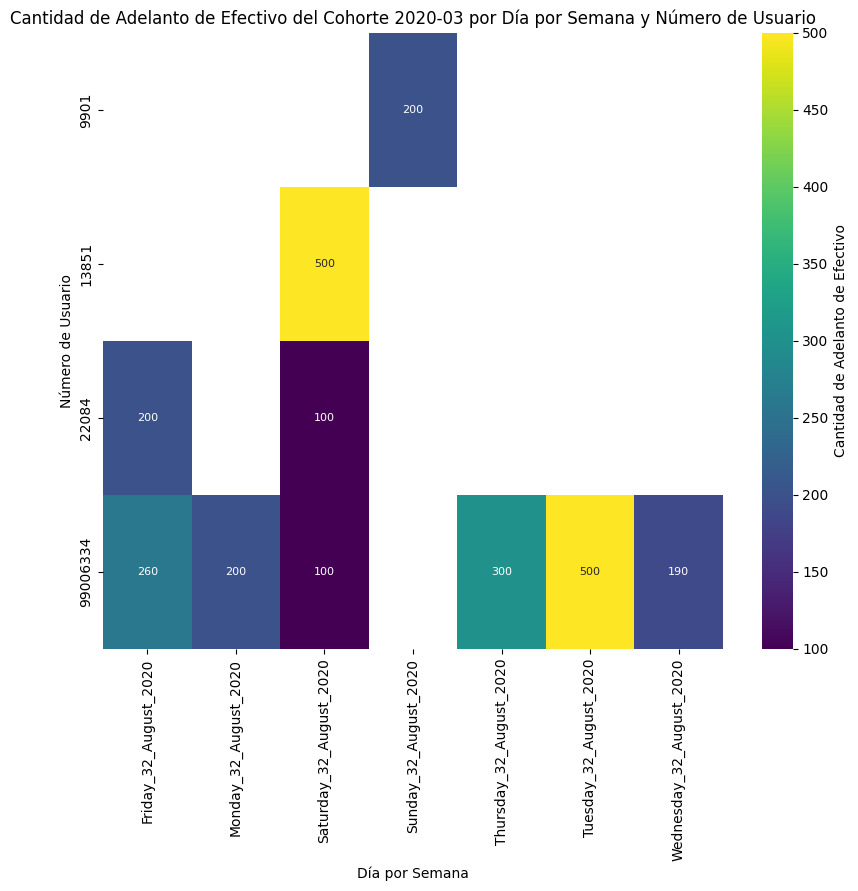

In [ ]:
# Graficar la cantidad de adelanto de efectivo de los 10 principales usuarios por día de la semana
plt.figure(figsize=(10, 8))
plt.title('Cantidad de Adelanto de Efectivo del Cohorte 2020-03 por Día por Semana y Número de Usuario')
sns.heatmap(data=cohort_daily_amount_top10, annot=True, fmt='.0f', cmap='viridis', annot_kws={"size": 8}, cbar_kws={'label': 'Cantidad de Adelanto de Efectivo'})
plt.xlabel('Día por Semana')
plt.ylabel('Número de Usuario')
plt.show()


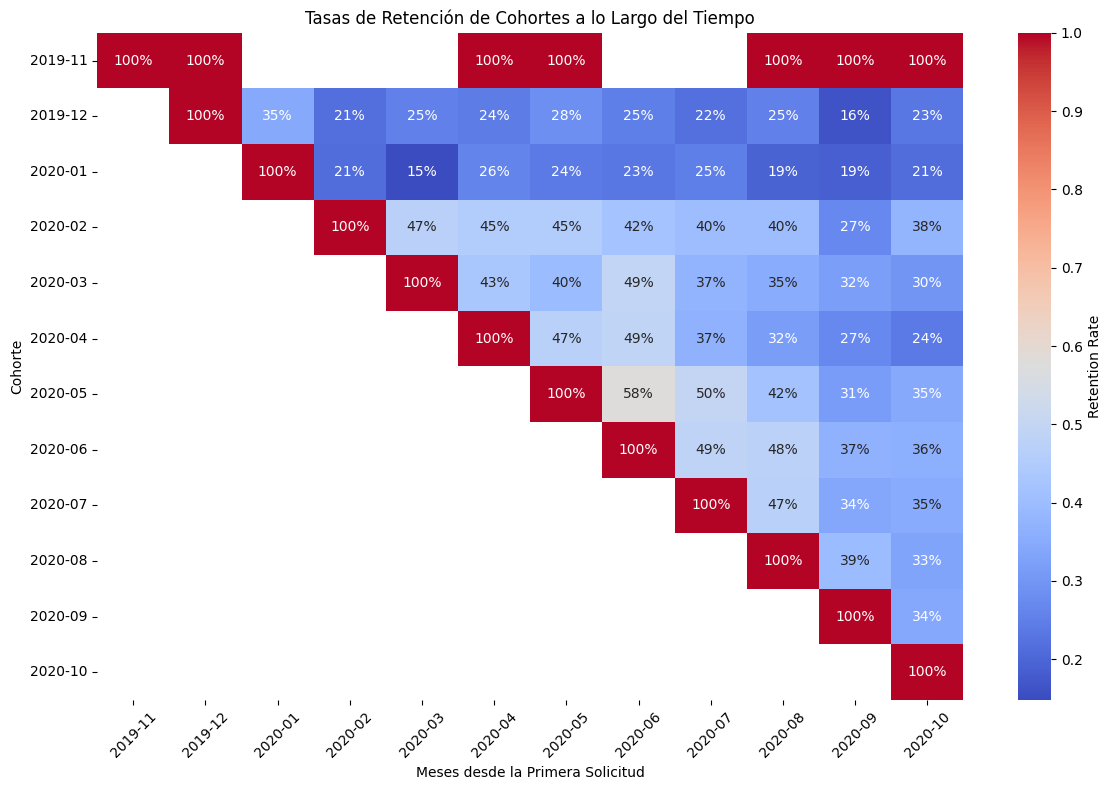

In [ ]:
# Calcular el tamaño inicial de las cohortes (primer mes de cada cohorte)
cohort_ltv_monthly['Clientes_Iniciales'] = cohort_ltv_monthly.groupby('Cohorte')['Clientes'].transform('first')

# Calcular las tasas de retención
cohort_ltv_monthly['Retention_Rate'] = cohort_ltv_monthly['Clientes'] / cohort_ltv_monthly['Clientes_Iniciales']

# Crear una matriz de retención
retention_matrix = cohort_ltv_monthly.pivot(index='Cohorte', columns='Mes_created_at', values='Retention_Rate')

# Crear el heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(
    retention_matrix, 
    annot=True, 
    fmt='.0%', 
    cmap='coolwarm', 
    cbar_kws={'label': 'Retention Rate'}
)
plt.title('Tasas de Retención de Cohortes a lo Largo del Tiempo')
plt.xlabel('Meses desde la Primera Solicitud')
plt.ylabel('Cohorte')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


